In [1]:
import sys
import eolearn
from eolearn.core import (
    FeatureType,
    MergeEOPatchesTask,
    EONode,
    linearly_connect_tasks,
    EOWorkflow,
    OutputTask
)
from eolearn.core.eoworkflow_tasks import InputTask
from eolearn.io import ImportFromTiffTask
from eolearn.ml_tools import TrainTestSplitTask

import os
import glob
import datetime
import dotenv

import rasterio as rio

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score, RepeatedKFold

root_dir = os.path.abspath('../')
if not root_dir in sys.path: sys.path.append(root_dir)

import eolearn_extras as eolx

In [2]:
dotenv.load_dotenv()
data_root_path = os.environ.get('data_root')
data_root_path

'D:/sdb_datasets'

In [3]:
sentinel_archives_root = os.path.abspath(os.path.join(data_root_path, 'sentinel_mile_lacs'))
sentinel_archives_pattern = f'{sentinel_archives_root}/*.SAFE'
sentinel_archives = glob.glob(sentinel_archives_pattern)
sentinel_archives

['D:\\sdb_datasets\\sentinel_mile_lacs\\S2A_MSIL1C_20210429T170851_N0300_R112_T15TVM_20210429T215623.SAFE',
 'D:\\sdb_datasets\\sentinel_mile_lacs\\S2A_MSIL1C_20210916T170941_N0301_R112_T15TVM_20210916T210302.SAFE',
 'D:\\sdb_datasets\\sentinel_mile_lacs\\S2A_MSIL1C_20211016T171311_N0301_R112_T15TVM_20211016T191815.SAFE',
 'D:\\sdb_datasets\\sentinel_mile_lacs\\S2A_MSIL1C_20211125T171641_N0301_R112_T15TVM_20211125T191313.SAFE',
 'D:\\sdb_datasets\\sentinel_mile_lacs\\S2A_MSIL2A_20211016T171311_N9999_R112_T15TVM_20220417T215507.SAFE',
 'D:\\sdb_datasets\\sentinel_mile_lacs\\S2A_MSIL2A_20211125T171641_N9999_R112_T15TVM_20220314T174330.SAFE',
 'D:\\sdb_datasets\\sentinel_mile_lacs\\S2B_MSIL1C_20211120T171619_N0301_R112_T15TVM_20211120T192246.SAFE',
 'D:\\sdb_datasets\\sentinel_mile_lacs\\S2B_MSIL1C_20211220T171719_N0301_R112_T15TVM_20211220T192125.SAFE',
 'D:\\sdb_datasets\\sentinel_mile_lacs\\S2B_MSIL1C_20220119T171629_N0301_R112_T15TVM_20220119T192108.SAFE',
 'D:\\sdb_datasets\\sentinel

In [4]:
l1c_products = eolx.io.get_products_by_level(sentinel_archives, 'L1C')
l1c_products

[(datetime.datetime(2021, 4, 29, 17, 8, 51),
  'D:\\sdb_datasets\\sentinel_mile_lacs\\S2A_MSIL1C_20210429T170851_N0300_R112_T15TVM_20210429T215623.SAFE'),
 (datetime.datetime(2021, 9, 16, 17, 9, 41),
  'D:\\sdb_datasets\\sentinel_mile_lacs\\S2A_MSIL1C_20210916T170941_N0301_R112_T15TVM_20210916T210302.SAFE'),
 (datetime.datetime(2021, 10, 16, 17, 13, 11),
  'D:\\sdb_datasets\\sentinel_mile_lacs\\S2A_MSIL1C_20211016T171311_N0301_R112_T15TVM_20211016T191815.SAFE'),
 (datetime.datetime(2021, 11, 20, 17, 16, 19),
  'D:\\sdb_datasets\\sentinel_mile_lacs\\S2B_MSIL1C_20211120T171619_N0301_R112_T15TVM_20211120T192246.SAFE'),
 (datetime.datetime(2021, 11, 25, 17, 16, 41),
  'D:\\sdb_datasets\\sentinel_mile_lacs\\S2A_MSIL1C_20211125T171641_N0301_R112_T15TVM_20211125T191313.SAFE'),
 (datetime.datetime(2021, 12, 20, 17, 17, 19),
  'D:\\sdb_datasets\\sentinel_mile_lacs\\S2B_MSIL1C_20211220T171719_N0301_R112_T15TVM_20211220T192125.SAFE'),
 (datetime.datetime(2022, 1, 19, 17, 16, 29),
  'D:\\sdb_datas

In [5]:
l2a_products = eolx.io.get_products_by_level(sentinel_archives, 'L2A')
l2a_products

[(datetime.datetime(2021, 10, 16, 17, 13, 11),
  'D:\\sdb_datasets\\sentinel_mile_lacs\\S2A_MSIL2A_20211016T171311_N9999_R112_T15TVM_20220417T215507.SAFE'),
 (datetime.datetime(2021, 11, 25, 17, 16, 41),
  'D:\\sdb_datasets\\sentinel_mile_lacs\\S2A_MSIL2A_20211125T171641_N9999_R112_T15TVM_20220314T174330.SAFE')]

In [7]:
import_millie_lacs = ImportFromTiffTask(
    (FeatureType.DATA_TIMELESS, 'bathy_data'),
    os.path.abspath(os.path.join(data_root_path, 'mille_lacs.tiff')),
)
reproject_bathy = eolx.raster.ReprojectRasterTask(
    (FeatureType.DATA_TIMELESS, 'bathy_data'),
    target_resolution=(10, 10),
)
append_bathy_data_mask = eolx.bathybase.AppendBathyTimelessDataMask((FeatureType.DATA_TIMELESS, 'bathy_data'), band_index=0)

output_label = 'millie_lacs_eop'
nodes = linearly_connect_tasks(
    import_millie_lacs,
    reproject_bathy,
    append_bathy_data_mask,
    OutputTask('millie_lacs_eop')
)
workflow = EOWorkflow(nodes)

worfklow_result = workflow.execute()
millie_lacs_eop = worfklow_result.outputs[output_label]

millie_lacs_eop

EOPatch(
  data_timeless={
    bathy_data: numpy.ndarray(shape=(2871, 2794, 1), dtype=float32)
  }
  mask_timeless={
    bathy_data_mask: numpy.ndarray(shape=(2871, 2794, 1), dtype=uint8)
  }
  bbox=BBox(((436481.4788999969, 5106398.035399999), (464421.4788999969, 5135108.035399999)), crs=CRS('26915'))
)

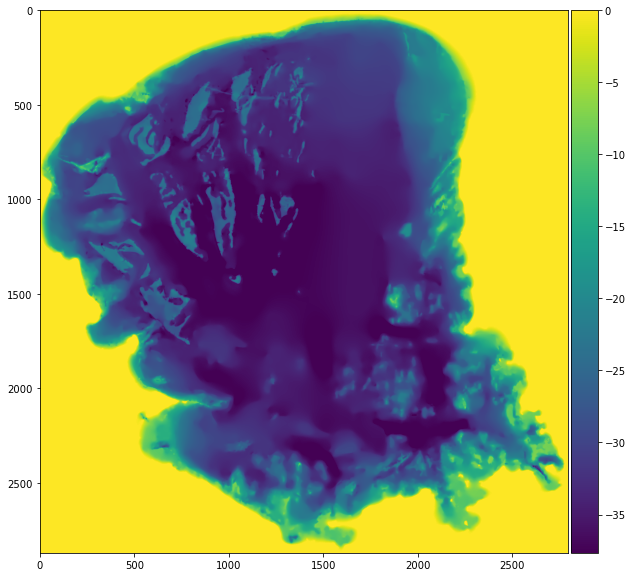

In [9]:
eolx.visualization.plot_single_band(millie_lacs_eop, (FeatureType.DATA_TIMELESS, 'bathy_data'), cmap='viridis')
plt.show()

In [10]:
height, width, _ = millie_lacs_eop[(FeatureType.DATA_TIMELESS, 'bathy_data')].shape
l2a_eopatch = eolx.io.construct_eopatch_from_sentinel_archive(l2a_products[0][1], target_shape=(height, width), bbox=millie_lacs_eop.bbox)
l2a_eopatch

EOPatch(
  data={
    L2A_data: numpy.ndarray(shape=(1, 2871, 2794, 12), dtype=uint16)
  }
  meta_info={
    mission: 'S2A'
  }
  bbox=BBox(((436481.4788999969, 5106398.035399999), (464421.4788999969, 5135108.035399999)), crs=CRS('26915'))
  timestamp=[datetime.datetime(2021, 10, 16, 17, 13, 11)]
)

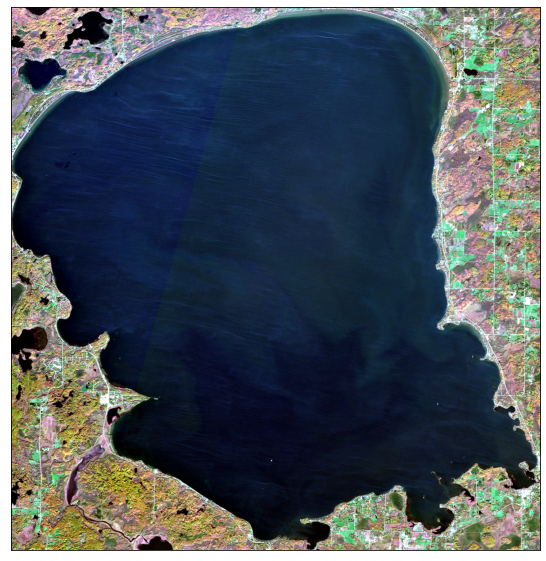

<AxesSubplot:>

In [11]:
eolx.visualization.plot_eopatch(
    l2a_eopatch,
    rgb_bands=eolx.visualization.sentinel_2_true_color,
    feature=(FeatureType.DATA, "L2A_data"),
    stretch=True
)

In [12]:
safe_archive_path = l1c_products[1][1]
height, width, _ = millie_lacs_eop[(FeatureType.DATA_TIMELESS, 'bathy_data')].shape
safe_eopatch = eolx.io.construct_eopatch_from_sentinel_archive(safe_archive_path, target_shape=(height, width), bbox=millie_lacs_eop.bbox)
safe_eopatch

EOPatch(
  data={
    L1C_data: numpy.ndarray(shape=(1, 2871, 2794, 13), dtype=uint16)
  }
  meta_info={
    mission: 'S2A'
  }
  bbox=BBox(((436481.4788999969, 5106398.035399999), (464421.4788999969, 5135108.035399999)), crs=CRS('26915'))
  timestamp=[datetime.datetime(2021, 9, 16, 17, 9, 41)]
)

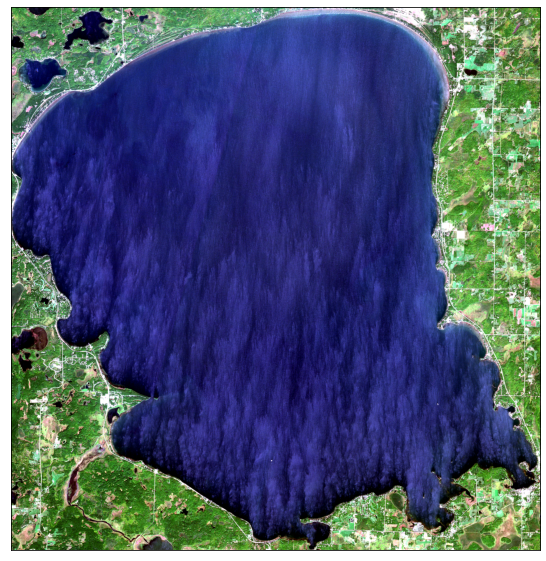

<AxesSubplot:>

In [13]:
eolx.visualization.plot_eopatch(
    safe_eopatch,
    rgb_bands=eolx.visualization.sentinel_2_true_color,
    feature=(FeatureType.DATA, "L1C_data"),
    stretch=True
)

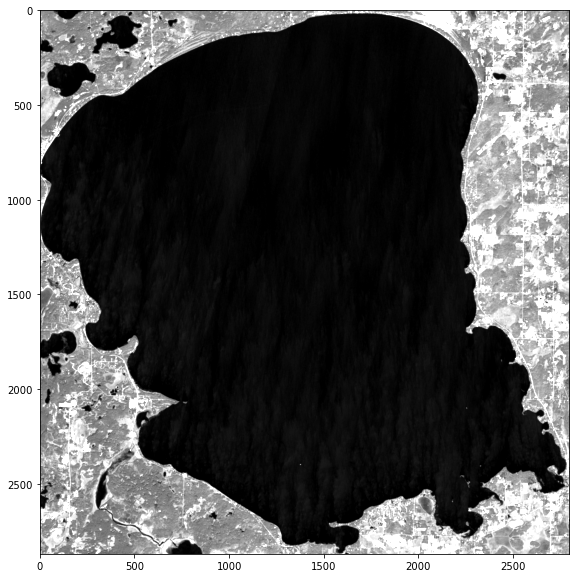

In [14]:
eolx.visualization.plot_single_band(
    safe_eopatch,
    (FeatureType.DATA, "L1C_data"),
    band_index=12,
    time_index=0,
    stretch=True,
    colorbar=False
)

In [16]:
sentinel_acolite_folder_pattern = f'{sentinel_archives_root}/*ACOLITE*'
sentinel_acolite_folders = glob.glob(sentinel_acolite_folder_pattern)
sentinel_acolite_folders


def get_acolite_band_tif_paths(folder, product_type='L2R', reflectance_type='rhos'):
    tif_pattern = f'{folder}/*_{product_type}_{reflectance_type}_*.tif'
    tifs = glob.glob(tif_pattern)
    return sorted(tifs, key=lambda x: int(os.path.basename(x).split('.')[0].split('_')[-1]))


acolite_band_tifs = get_acolite_band_tif_paths(sentinel_acolite_folders[0])
acolite_band_tifs

['D:\\sdb_datasets\\sentinel_mile_lacs\\S2A_20211016T171311_ACOLITE_SUBSET\\S2A_MSI_2021_10_16_17_20_57_T15TVM_L2R_rhos_443.tif',
 'D:\\sdb_datasets\\sentinel_mile_lacs\\S2A_20211016T171311_ACOLITE_SUBSET\\S2A_MSI_2021_10_16_17_20_57_T15TVM_L2R_rhos_492.tif',
 'D:\\sdb_datasets\\sentinel_mile_lacs\\S2A_20211016T171311_ACOLITE_SUBSET\\S2A_MSI_2021_10_16_17_20_57_T15TVM_L2R_rhos_560.tif',
 'D:\\sdb_datasets\\sentinel_mile_lacs\\S2A_20211016T171311_ACOLITE_SUBSET\\S2A_MSI_2021_10_16_17_20_57_T15TVM_L2R_rhos_665.tif',
 'D:\\sdb_datasets\\sentinel_mile_lacs\\S2A_20211016T171311_ACOLITE_SUBSET\\S2A_MSI_2021_10_16_17_20_57_T15TVM_L2R_rhos_704.tif',
 'D:\\sdb_datasets\\sentinel_mile_lacs\\S2A_20211016T171311_ACOLITE_SUBSET\\S2A_MSI_2021_10_16_17_20_57_T15TVM_L2R_rhos_740.tif',
 'D:\\sdb_datasets\\sentinel_mile_lacs\\S2A_20211016T171311_ACOLITE_SUBSET\\S2A_MSI_2021_10_16_17_20_57_T15TVM_L2R_rhos_783.tif',
 'D:\\sdb_datasets\\sentinel_mile_lacs\\S2A_20211016T171311_ACOLITE_SUBSET\\S2A_MSI_2021_1

In [17]:
def get_info_for_acolite_tif_path(acolite_tif_path):
    bn = os.path.basename(acolite_tif_path)
    parts = bn.split('.')[0].split('_')
    mission, instrument, year, month, day, hour, minute, second, _, product, reflectance_type, center_freq = parts

    return reflectance_type, center_freq, datetime.datetime(int(year), int(month), int(day), int(hour), int(minute), int(second))

In [18]:
def get_eopatch_for_acolite_band_tif(band_tif_path, reference_bbox, feature):
    reflectance_type, center_freq, ts = get_info_for_acolite_tif_path(band_tif_path)

    feature_type, feature_name = feature
    feature = (feature_type, f'{feature_name}_{reflectance_type}_{center_freq}')

    import_acolite_band = ImportFromTiffTask(feature, band_tif_path)
    reproject_acolite_band = eolx.raster.ReprojectRasterTask(
        feature,
        target_crs=rio.crs.CRS.from_epsg(reference_bbox.crs.epsg),
        target_resolution=(10, 10)
    )
    clip_acolite_band = eolx.raster.ClipBoxTask(feature, target_bounds=reference_bbox)

    acolite_band_output_label = 'acolite_band_output'
    wf = EOWorkflow(
        linearly_connect_tasks(
            import_acolite_band,
            reproject_acolite_band,
            clip_acolite_band,
            OutputTask(acolite_band_output_label)
        )
    )

    acolite_band_patch = wf.execute().outputs[acolite_band_output_label]
    acolite_band_patch.timestamp = [ts]

    # TODO: think about a better fix for wrong atmospheric correction
    print(np.sum(acolite_band_patch[feature] < 0))
    acolite_band_patch[feature][acolite_band_patch[feature] < 0] = 0

    return acolite_band_patch


acolite_image_bands = [get_eopatch_for_acolite_band_tif(os.path.abspath(x), millie_lacs_eop.bbox, (FeatureType.DATA, 'L2R_data')) for x in acolite_band_tifs]
len(acolite_image_bands)

6635
1037
2
0
0
72
77
2
152
11439
92212


11

In [19]:
acolite_image_bands[2]

EOPatch(
  data={
    L2R_data_rhos_560: numpy.ndarray(shape=(1, 2871, 2794, 1), dtype=float32)
  }
  bbox=BBox(((436481.4788999969, 5106398.035399999), (464421.4788999969, 5135108.035399999)), crs=CRS('26915'))
  timestamp=[datetime.datetime(2021, 10, 16, 17, 20, 57)]
)

In [20]:
merge_acolite_bands = MergeEOPatchesTask()
acolite_test_image = merge_acolite_bands.execute(*acolite_image_bands)
merge_band_data = eolearn.core.MergeFeatureTask(
    [(FeatureType.DATA, x) for x in sorted(acolite_test_image.get_features()[(FeatureType.DATA)], key=lambda x: int(x.split('_')[-1]))],
    (FeatureType.DATA, 'L2R_data')
)
merge_band_data.execute(acolite_test_image)
acolite_test_image

EOPatch(
  data={
    L2R_data: numpy.ndarray(shape=(1, 2871, 2794, 11), dtype=float32)
    L2R_data_rhos_1614: numpy.ndarray(shape=(1, 2871, 2794, 1), dtype=float32)
    L2R_data_rhos_2202: numpy.ndarray(shape=(1, 2871, 2794, 1), dtype=float32)
    L2R_data_rhos_443: numpy.ndarray(shape=(1, 2871, 2794, 1), dtype=float32)
    L2R_data_rhos_492: numpy.ndarray(shape=(1, 2871, 2794, 1), dtype=float32)
    L2R_data_rhos_560: numpy.ndarray(shape=(1, 2871, 2794, 1), dtype=float32)
    L2R_data_rhos_665: numpy.ndarray(shape=(1, 2871, 2794, 1), dtype=float32)
    L2R_data_rhos_704: numpy.ndarray(shape=(1, 2871, 2794, 1), dtype=float32)
    L2R_data_rhos_740: numpy.ndarray(shape=(1, 2871, 2794, 1), dtype=float32)
    L2R_data_rhos_783: numpy.ndarray(shape=(1, 2871, 2794, 1), dtype=float32)
    L2R_data_rhos_833: numpy.ndarray(shape=(1, 2871, 2794, 1), dtype=float32)
    L2R_data_rhos_865: numpy.ndarray(shape=(1, 2871, 2794, 1), dtype=float32)
  }
  bbox=BBox(((436481.4788999969, 5106398.0353999

In [21]:
np.sum(acolite_test_image[(FeatureType.DATA, 'L2R_data')] < 0)

0

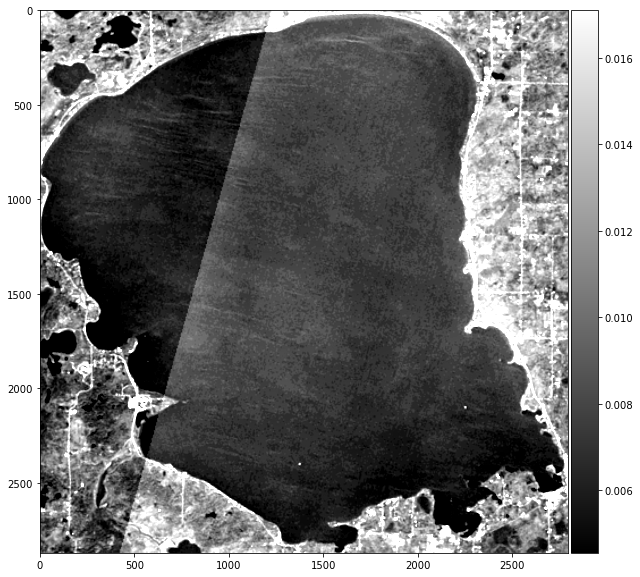

In [22]:
eolx.visualization.plot_single_band(acolite_test_image, (FeatureType.DATA, 'L2R_data'))

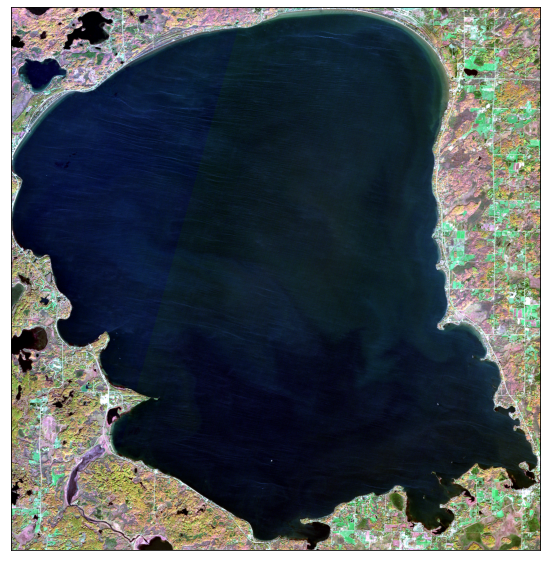

<AxesSubplot:>

In [23]:
eolx.visualization.plot_eopatch(
    acolite_test_image,
    rgb_bands=eolx.visualization.sentinel_2_true_color,
    feature=(FeatureType.DATA, "L2R_data"),
    stretch=True
)

In [24]:
merge_patches_task = MergeEOPatchesTask()
merged_eop = merge_patches_task.execute(millie_lacs_eop, safe_eopatch, l2a_eopatch, acolite_test_image)
merged_eop

EOPatch(
  data={
    L1C_data: numpy.ndarray(shape=(1, 2871, 2794, 13), dtype=uint16)
    L2A_data: numpy.ndarray(shape=(1, 2871, 2794, 12), dtype=uint16)
    L2R_data: numpy.ndarray(shape=(1, 2871, 2794, 11), dtype=float32)
    L2R_data_rhos_1614: numpy.ndarray(shape=(1, 2871, 2794, 1), dtype=float32)
    L2R_data_rhos_2202: numpy.ndarray(shape=(1, 2871, 2794, 1), dtype=float32)
    L2R_data_rhos_443: numpy.ndarray(shape=(1, 2871, 2794, 1), dtype=float32)
    L2R_data_rhos_492: numpy.ndarray(shape=(1, 2871, 2794, 1), dtype=float32)
    L2R_data_rhos_560: numpy.ndarray(shape=(1, 2871, 2794, 1), dtype=float32)
    L2R_data_rhos_665: numpy.ndarray(shape=(1, 2871, 2794, 1), dtype=float32)
    L2R_data_rhos_704: numpy.ndarray(shape=(1, 2871, 2794, 1), dtype=float32)
    L2R_data_rhos_740: numpy.ndarray(shape=(1, 2871, 2794, 1), dtype=float32)
    L2R_data_rhos_783: numpy.ndarray(shape=(1, 2871, 2794, 1), dtype=float32)
    L2R_data_rhos_833: numpy.ndarray(shape=(1, 2871, 2794, 1), dtype=f

In [25]:
data_feature = (FeatureType.MASK_TIMELESS, 'bathy_data_mask')
train_test_mask_feature = (FeatureType.MASK_TIMELESS, 'train_test_split')

train_test_split_task = TrainTestSplitTask(
    input_feature=data_feature,
    output_feature=train_test_mask_feature,
    bins=[0.8],
    split_type=eolearn.ml_tools.train_test_split.TrainTestSplitType.PER_PIXEL,
)

valid_train_test_data_mask_task = eolx.ml_util.AddValidTrainTestMasks(
    train_test_maks_feature=train_test_mask_feature,
    valid_data_mask_feature=data_feature
)

input_task = InputTask(merged_eop)
input_node = EONode(input_task, inputs=tuple())

train_test_split_node = EONode(train_test_split_task, inputs=[input_node])
valid_train_test_data_mask_node = EONode(valid_train_test_data_mask_task, inputs=[train_test_split_node])

tt_wf_output_label = 'tt_wf_output'
output_task = OutputTask(tt_wf_output_label)
output_node = EONode(output_task, inputs=[valid_train_test_data_mask_node])

train_test_wf = EOWorkflow(
    [
        input_node,
        train_test_split_node,
        valid_train_test_data_mask_node,
        output_node
    ]
)

tt_wf_res = train_test_wf.execute(
    input_kwargs={
        train_test_split_node: {'seed': 42}
    }
)

train_test_eop = tt_wf_res.outputs[tt_wf_output_label]
train_test_eop

EOPatch(
  data={
    L1C_data: numpy.ndarray(shape=(1, 2871, 2794, 13), dtype=uint16)
    L2A_data: numpy.ndarray(shape=(1, 2871, 2794, 12), dtype=uint16)
    L2R_data: numpy.ndarray(shape=(1, 2871, 2794, 11), dtype=float32)
    L2R_data_rhos_1614: numpy.ndarray(shape=(1, 2871, 2794, 1), dtype=float32)
    L2R_data_rhos_2202: numpy.ndarray(shape=(1, 2871, 2794, 1), dtype=float32)
    L2R_data_rhos_443: numpy.ndarray(shape=(1, 2871, 2794, 1), dtype=float32)
    L2R_data_rhos_492: numpy.ndarray(shape=(1, 2871, 2794, 1), dtype=float32)
    L2R_data_rhos_560: numpy.ndarray(shape=(1, 2871, 2794, 1), dtype=float32)
    L2R_data_rhos_665: numpy.ndarray(shape=(1, 2871, 2794, 1), dtype=float32)
    L2R_data_rhos_704: numpy.ndarray(shape=(1, 2871, 2794, 1), dtype=float32)
    L2R_data_rhos_740: numpy.ndarray(shape=(1, 2871, 2794, 1), dtype=float32)
    L2R_data_rhos_783: numpy.ndarray(shape=(1, 2871, 2794, 1), dtype=float32)
    L2R_data_rhos_833: numpy.ndarray(shape=(1, 2871, 2794, 1), dtype=f

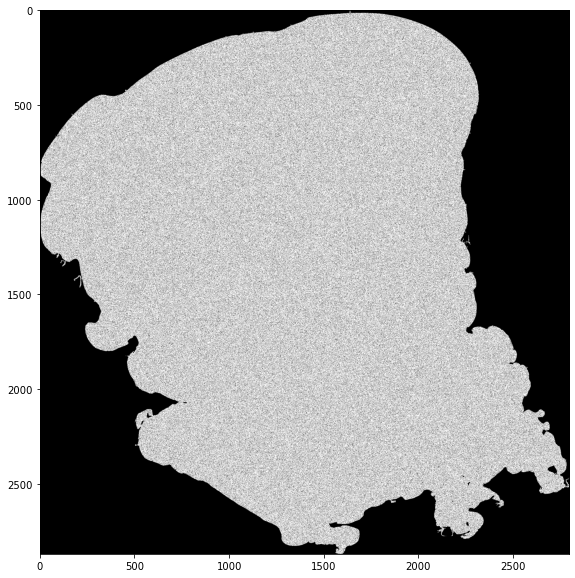

In [26]:
eolx.visualization.plot_single_band(train_test_eop, (FeatureType.MASK_TIMELESS, 'train_split_valid'), colorbar=False)

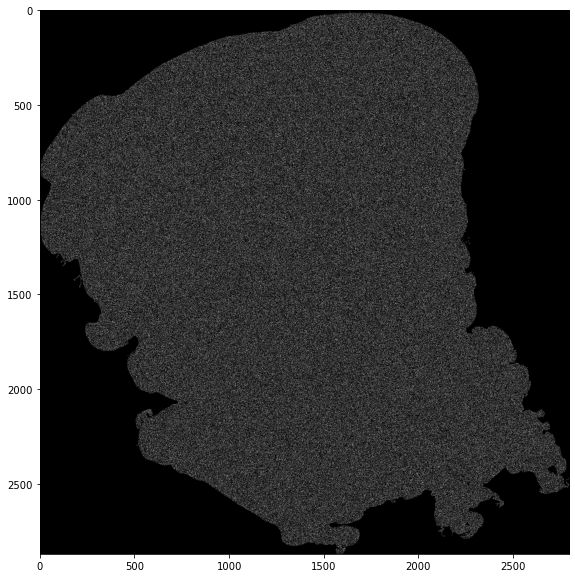

In [27]:
eolx.visualization.plot_single_band(train_test_eop, (FeatureType.MASK_TIMELESS, 'test_split_valid'), colorbar=False)

In [28]:
traincount = train_test_eop.meta_info['train_count']
testcount = train_test_eop.meta_info['test_count']
traincount, testcount

(4159120, 1039055)

### L1C Testing

In [29]:
all_band_train_index = np.repeat(train_test_eop[(FeatureType.MASK_TIMELESS, 'train_split_valid')], repeats=13, axis=-1)
X = np.reshape(train_test_eop[(FeatureType.DATA, 'L1C_data')][0,:,:,:][all_band_train_index == 1], (traincount, 13))
y = train_test_eop[(FeatureType.DATA_TIMELESS, 'bathy_data')][train_test_eop[(FeatureType.MASK_TIMELESS, 'train_split_valid')] == 1]
X.shape, y.shape

((4159120, 13), (4159120,))

In [30]:
model = LGBMRegressor()
cv = RepeatedKFold(n_splits=3, n_repeats=1, random_state=42)
n_scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv)
np.mean(n_scores), np.std(n_scores)

(-16.94908220853831, 0.030469989001368932)

In [31]:
model = LGBMRegressor()
model.fit(X, y)

LGBMRegressor()

In [32]:
all_band_test_index = np.repeat(train_test_eop[(FeatureType.MASK_TIMELESS, 'test_split_valid')], repeats=13, axis=-1)
X_test = np.reshape(train_test_eop[(FeatureType.DATA, 'L1C_data')][0,:,:,:][all_band_test_index == 1], (testcount, 13))
y_test = train_test_eop[(FeatureType.DATA_TIMELESS, 'bathy_data')][train_test_eop[(FeatureType.MASK_TIMELESS, 'test_split_valid')] == 1]
X_test.shape, y_test.shape

((1039055, 13), (1039055,))

In [33]:
from sklearn.metrics import mean_squared_error

y_hat_test = model.predict(X_test)

-mean_squared_error(y_test, y_hat_test)

-16.95338010144325

In [34]:
bathy_pixels = np.sum(train_test_eop[(FeatureType.MASK_TIMELESS, 'bathy_data_mask')] == 1)

all_band_index_complete = np.repeat(train_test_eop[(FeatureType.MASK_TIMELESS, 'bathy_data_mask')], repeats=13, axis=-1)
X_all = np.reshape(train_test_eop[(FeatureType.DATA, 'L1C_data')][0,:,:,:][all_band_index_complete == 1], (bathy_pixels, 13))

y_hat_all = model.predict(X_all)
empty_validation_target = np.zeros(train_test_eop[(FeatureType.MASK_TIMELESS, 'bathy_data_mask')].shape)
empty_validation_target[train_test_eop[(FeatureType.MASK_TIMELESS, 'bathy_data_mask')] == 1] = y_hat_all

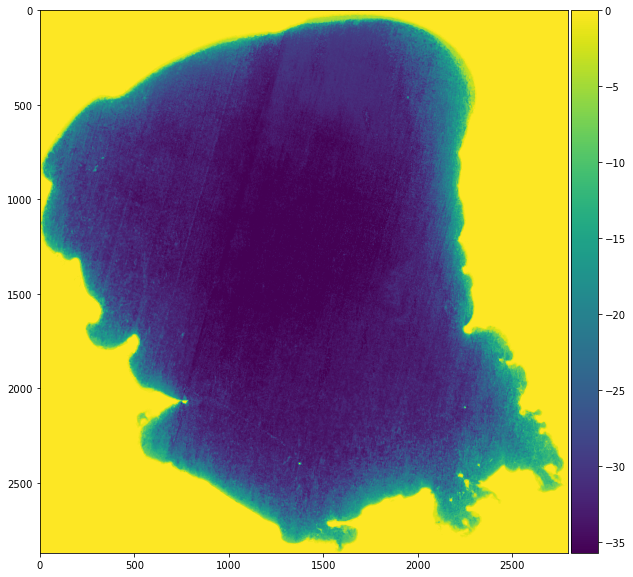

In [35]:
eolx.visualization.plot_ndarray_band(empty_validation_target, cmap='viridis')

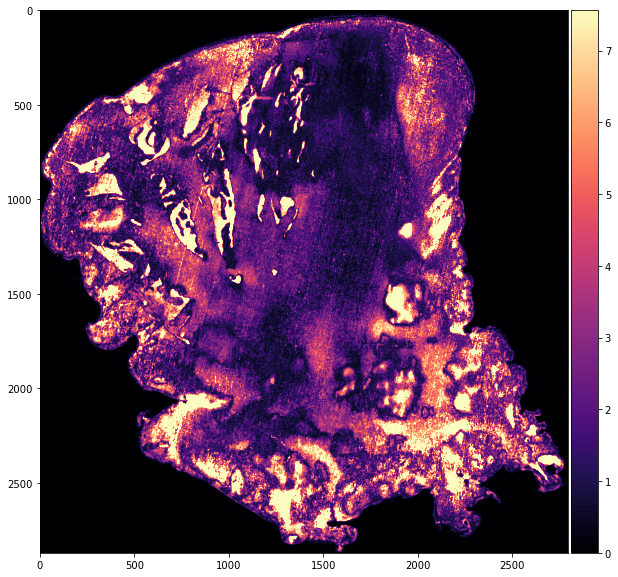

In [36]:
eolx.visualization.plot_ndarray_band(np.abs(empty_validation_target - train_test_eop[(FeatureType.DATA_TIMELESS, 'bathy_data')]), cmap='magma')

### L2A Testing

In [32]:
all_band_train_index = np.repeat(train_test_eop[(FeatureType.MASK_TIMELESS, 'train_split_valid')], repeats=12, axis=-1)
X = np.reshape(train_test_eop[(FeatureType.DATA, 'L2A_data')][0,:,:,:][all_band_train_index == 1], (traincount, 12))
y = train_test_eop[(FeatureType.DATA_TIMELESS, 'bathy_data')][train_test_eop[(FeatureType.MASK_TIMELESS, 'train_split_valid')] == 1]
X.shape, y.shape

((4159120, 12), (4159120,))

In [33]:
model = LGBMRegressor()
cv = RepeatedKFold(n_splits=3, n_repeats=1, random_state=42)
n_scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv)
np.mean(n_scores), np.std(n_scores)

(-24.980478168837863, 0.022773933190237745)

In [34]:
model = LGBMRegressor()
model.fit(X, y)

LGBMRegressor()

In [35]:
bathy_pixels = np.sum(train_test_eop[(FeatureType.MASK_TIMELESS, 'bathy_data_mask')] == 1)

all_band_index_complete = np.repeat(train_test_eop[(FeatureType.MASK_TIMELESS, 'bathy_data_mask')], repeats=12, axis=-1)
X_all = np.reshape(train_test_eop[(FeatureType.DATA, 'L2A_data')][0,:,:,:][all_band_index_complete == 1], (bathy_pixels, 12))

y_hat_all = model.predict(X_all)
empty_validation_target = np.zeros(train_test_eop[(FeatureType.MASK_TIMELESS, 'bathy_data_mask')].shape)
empty_validation_target[train_test_eop[(FeatureType.MASK_TIMELESS, 'bathy_data_mask')] == 1] = y_hat_all

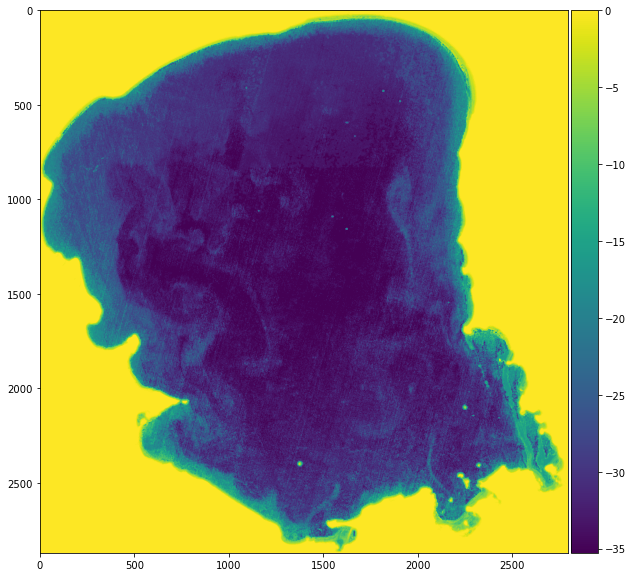

In [36]:
eolx.visualization.plot_ndarray_band(empty_validation_target, cmap='viridis')

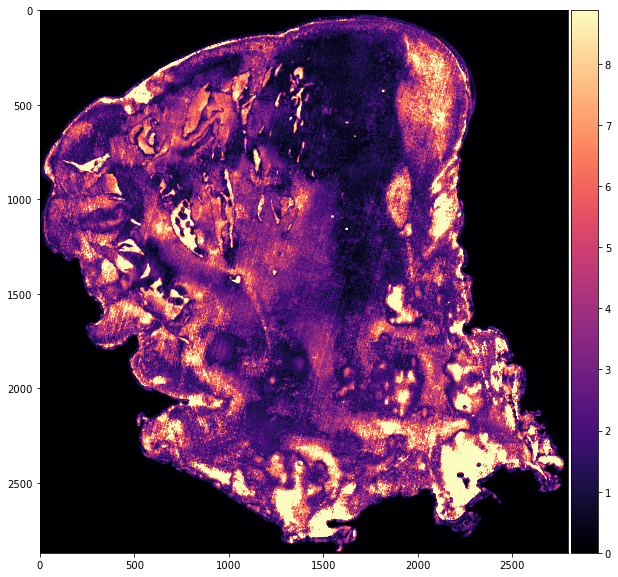

In [37]:
eolx.visualization.plot_ndarray_band(np.abs(empty_validation_target - train_test_eop[(FeatureType.DATA_TIMELESS, 'bathy_data')]), cmap='magma')